### Trabajo Final Master Ciencia de Datos y Business Analytics
## Reporte Laboratorio Seco - EDA Juego de Datos
Actualizado agosto 1, 2023

## Introducción
El propósito del siguiente cuaderno de laboratorio seco es el registro del proceso de EDA (Exploratory Data Analysis) o análisis exploratorio de la data de Sportline América Colombia. En estadística, el análisis exploratorio de datos (EDA) es un enfoque que consiste en analizar conjuntos de datos para resumir sus características principales, a menudo utilizando gráficos estadísticos y otros métodos de visualización de datos. Se puede utilizar un modelo estadístico o no, pero principalmente EDA sirve para ver qué nos pueden decir los datos más allá del modelado formal y, por lo tanto, contrastar las pruebas de hipótesis tradicionales.

## Ingesta de la Data
El primer paso del proceso es la ingesta de la data para el análisis.

In [1]:
import pandas as pd
csv_file_path = '/Users/ameilij/Documents/Academia/Master Data Science/MDS/tfm/data_clean/master_POS_SLA_COL_diario.csv'
encoding = 'latin1'
dfPOS = pd.read_csv(csv_file_path, encoding=encoding)
dfPOS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9069 entries, 0 to 9068
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CODIGO_MARCA  9069 non-null   float64
 1   FECHA         9069 non-null   object 
 2   CANTIDAD      9069 non-null   int64  
 3   WEEK_OF_YEAR  9069 non-null   object 
 4   YEAR          9069 non-null   int64  
 5   MONTH         9069 non-null   object 
 6   XMAS          9069 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 496.1+ KB


Se ajustan ciertas columnas para devolver los tipos de datos que se pierden al almacenar como CSV.

In [2]:
dfPOS['FECHA'] = pd.to_datetime(dfPOS['FECHA'], format= '%Y-%m-%d')
dfPOS['WEEK_LAST_TWO_DIGITS'] = dfPOS['WEEK_OF_YEAR'].str[-2:]
dfPOS['WEEK_LAST_TWO_DIGITS'] = pd.to_numeric(dfPOS['WEEK_LAST_TWO_DIGITS'])

dfPOS['YEAR'] = dfPOS['FECHA'].dt.year
dfPOS['MONTH'] = dfPOS['FECHA'].dt.month
dfPOS['XMAS'] = dfPOS['MONTH'].apply(lambda x: 1 if x == 1 else 0)

## Estudiando las Variables del Juego de Datos
El primer punto de partida en el análisis EDA fue utilizar la libreria __SweetViz__ para tener una lectura preliminar de los datos. Sweetviz es una biblioteca Python de código abierto que genera hermosas visualizaciones de alta densidad para iniciar EDA (Análisis de datos exploratorios) con solo dos líneas de código. El resultado es una aplicación HTML totalmente autónoma.

El sistema se basa en la visualización rápida de valores objetivo y la comparación de conjuntos de datos. Su objetivo es ayudar a realizar un análisis rápido de las características del objetivo, datos de entrenamiento frente a pruebas y otras tareas similares de caracterización de datos.

                                             |                                                                …


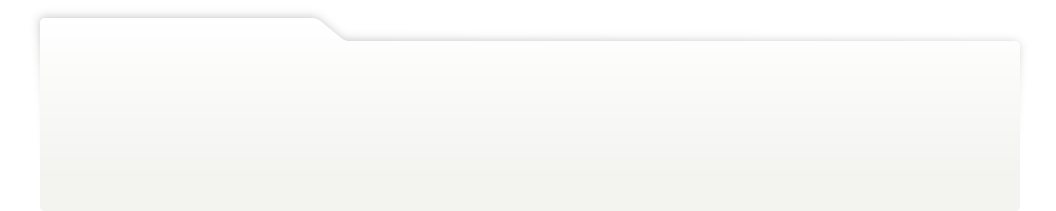
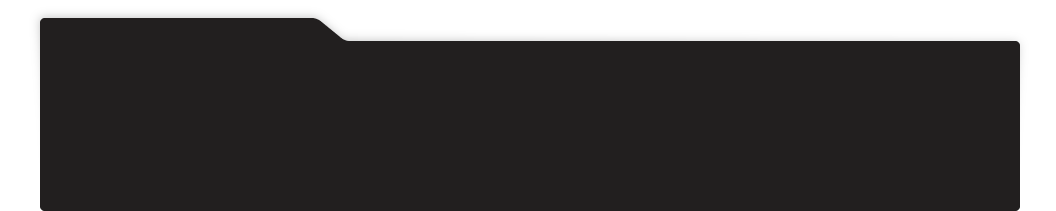
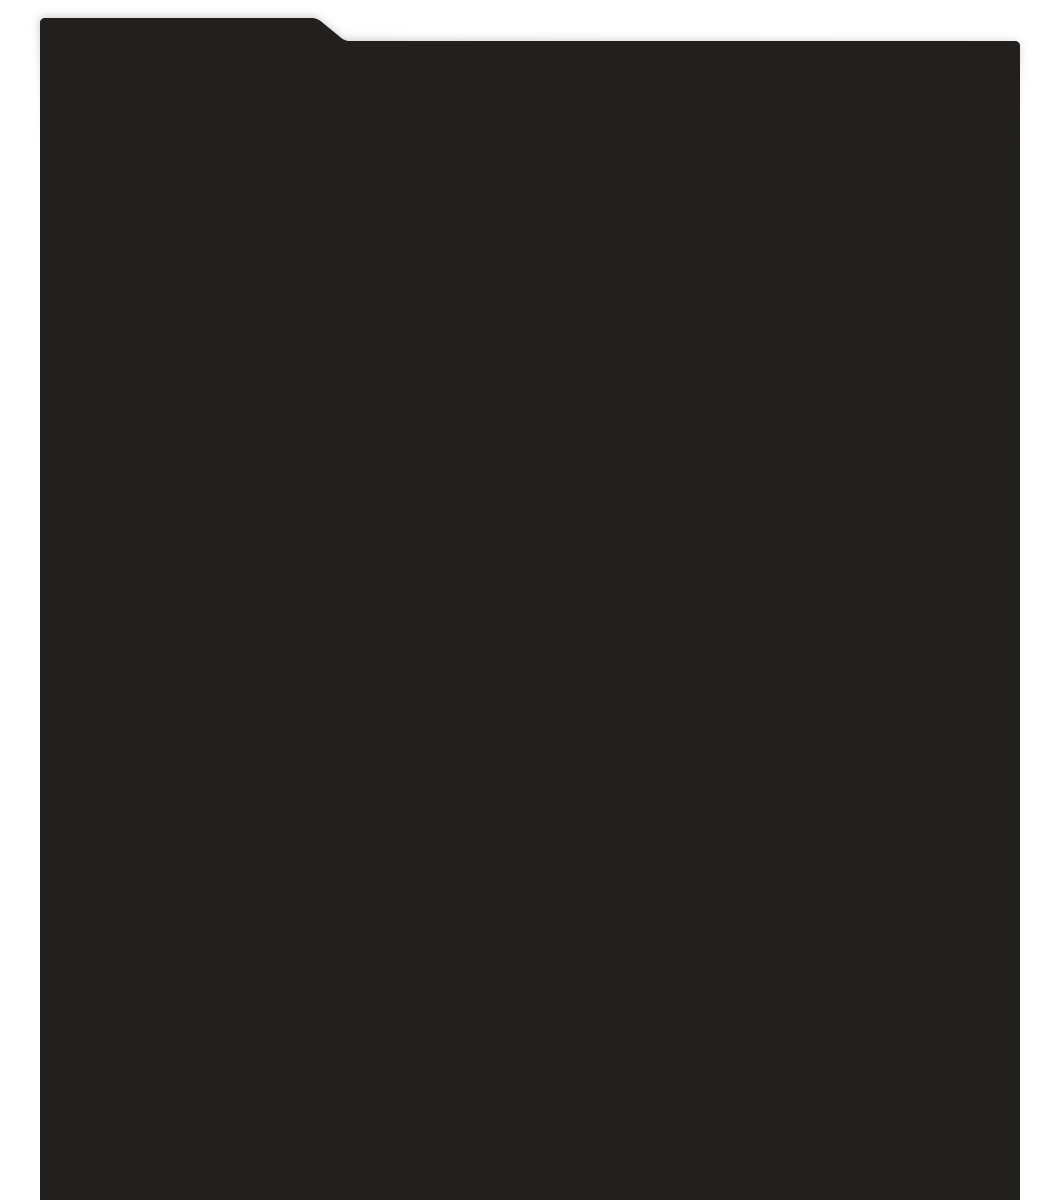
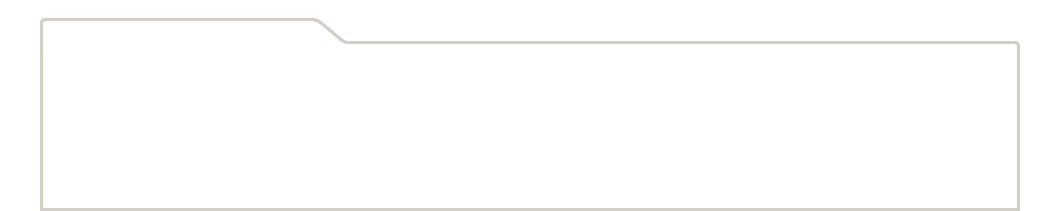
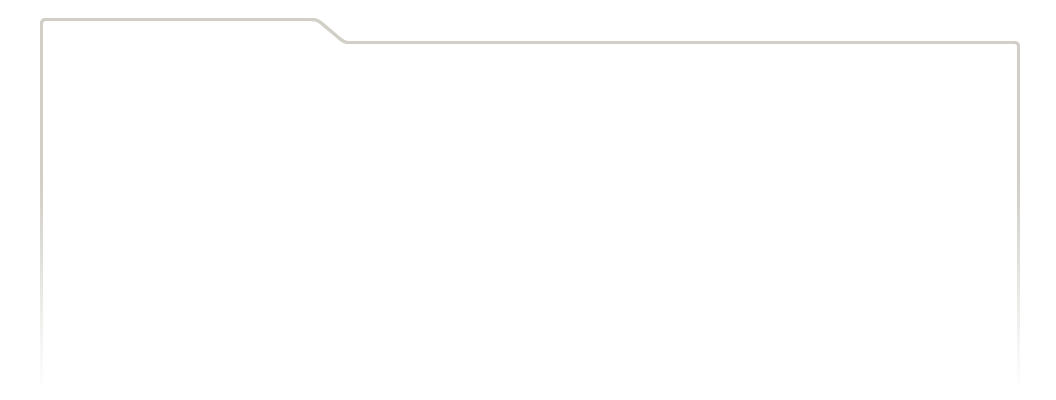
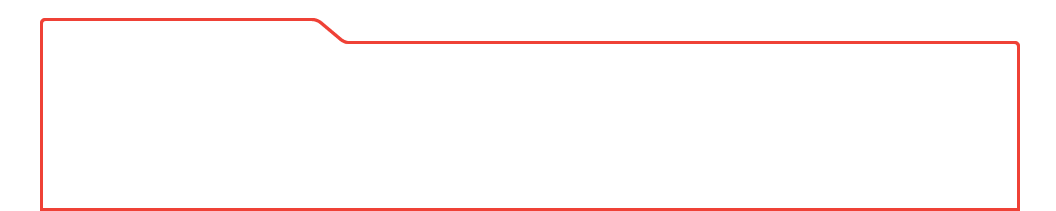
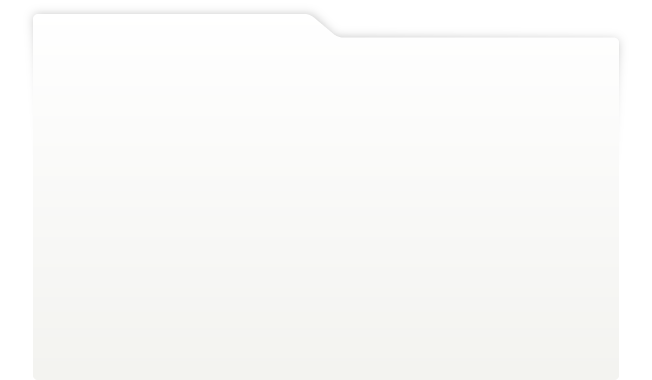
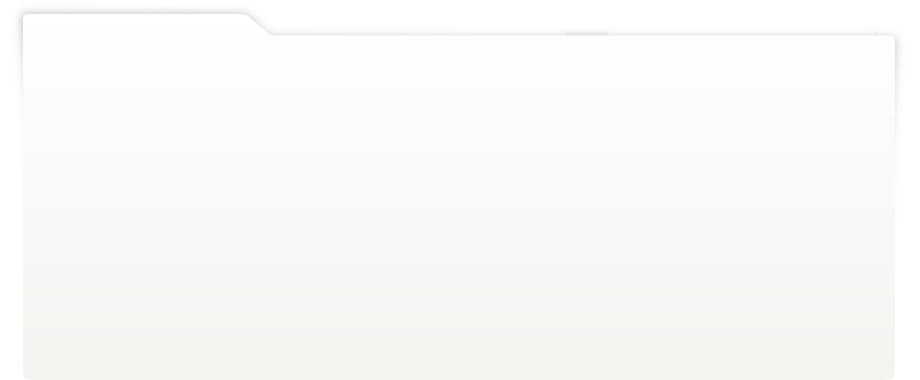
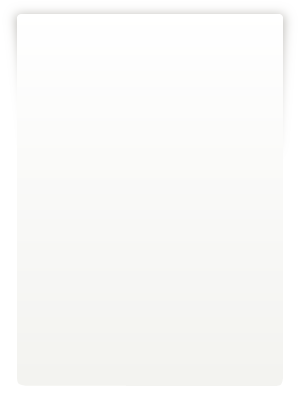
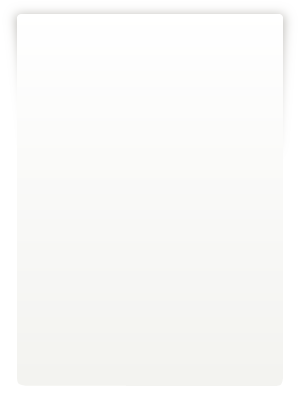
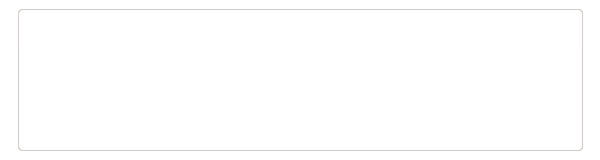
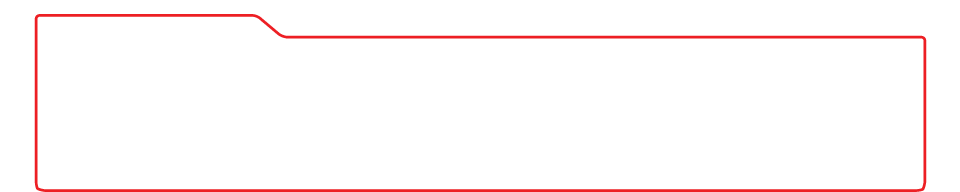
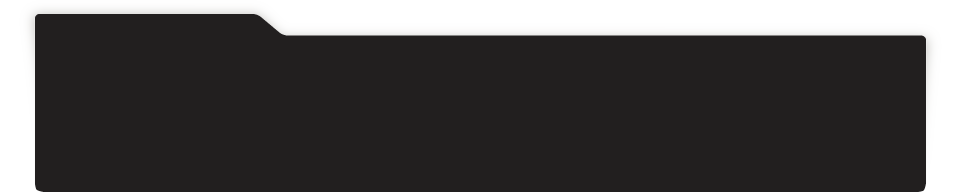
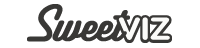
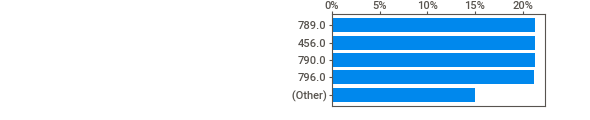
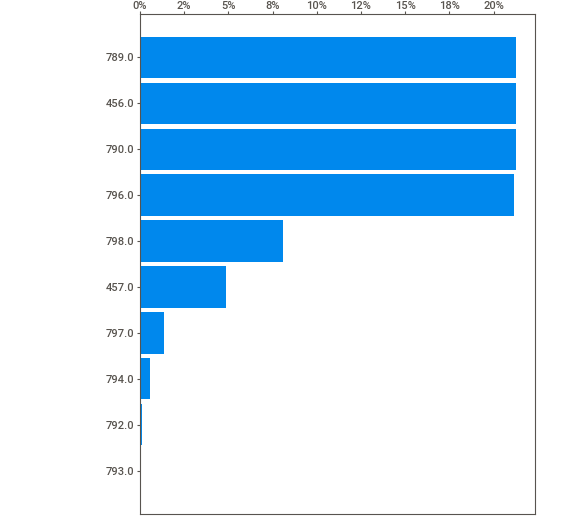
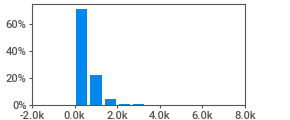
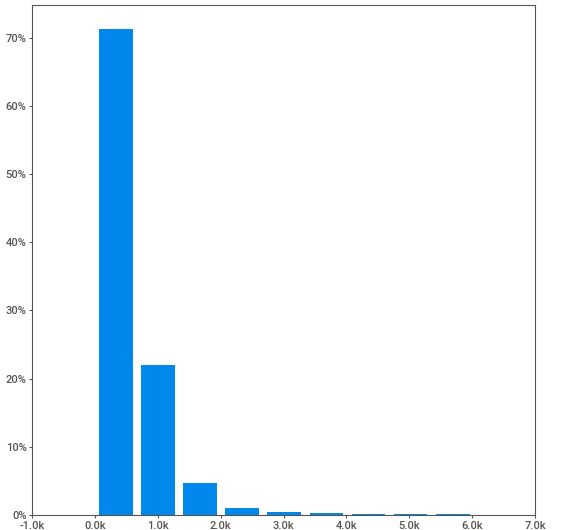
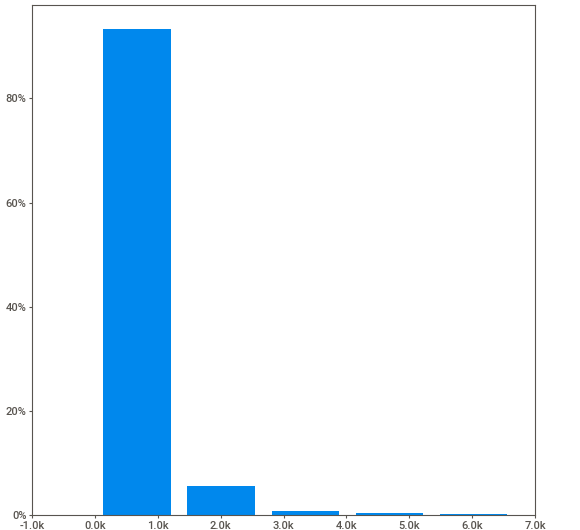
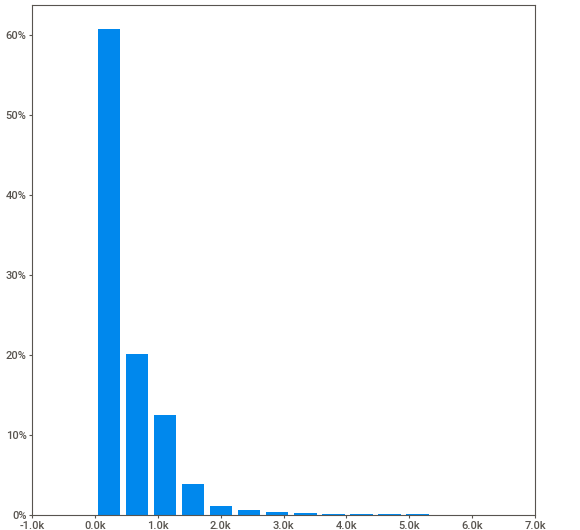
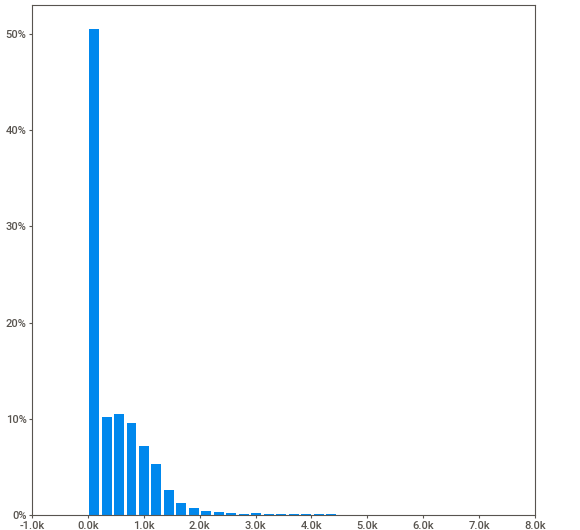
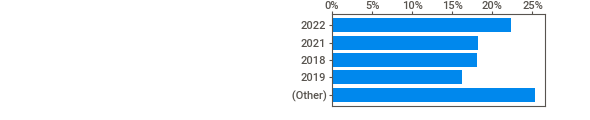
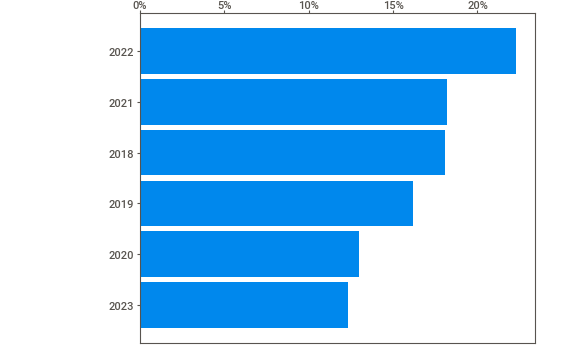
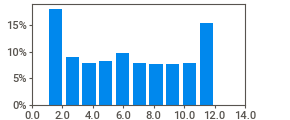
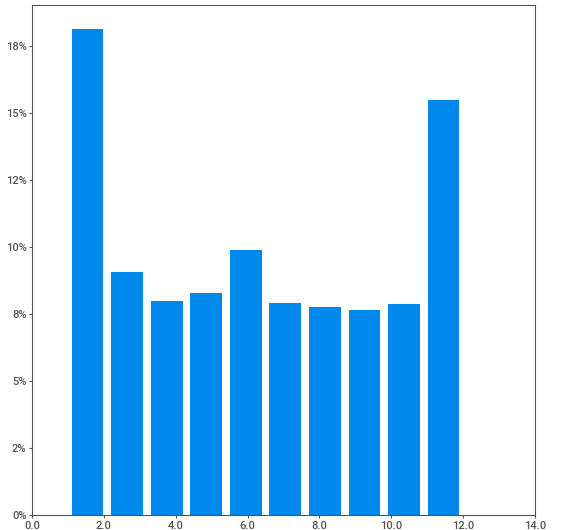
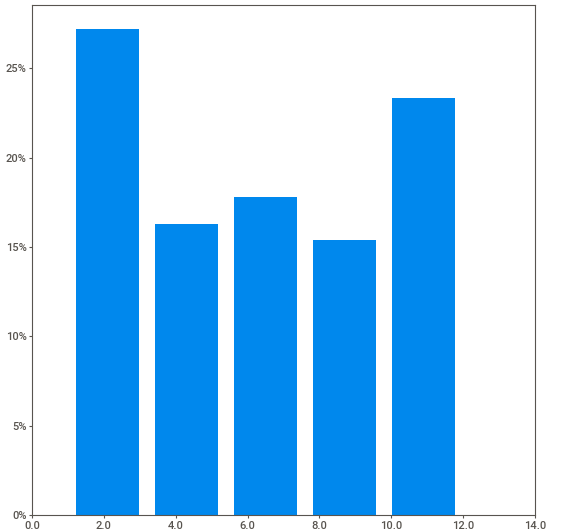
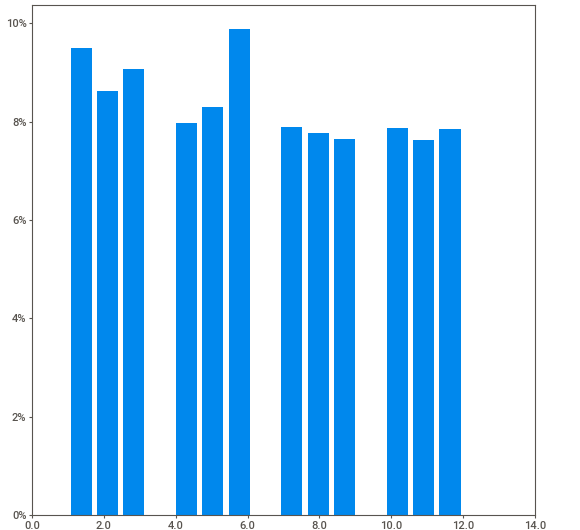
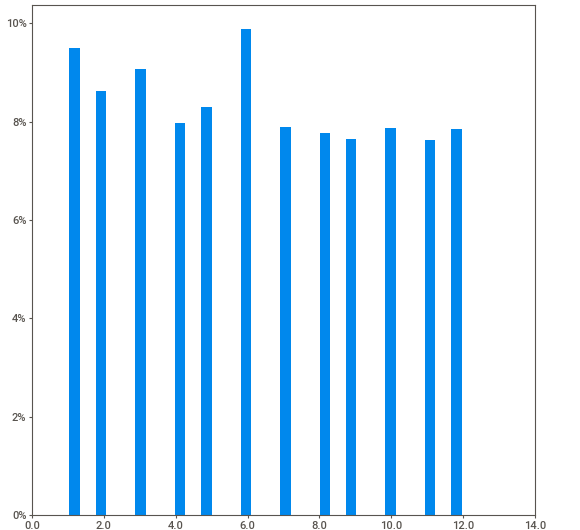
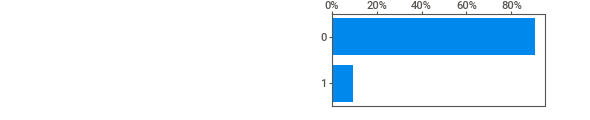
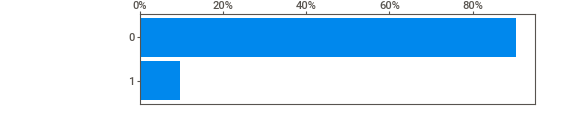
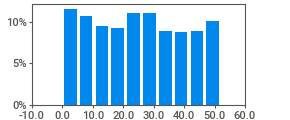
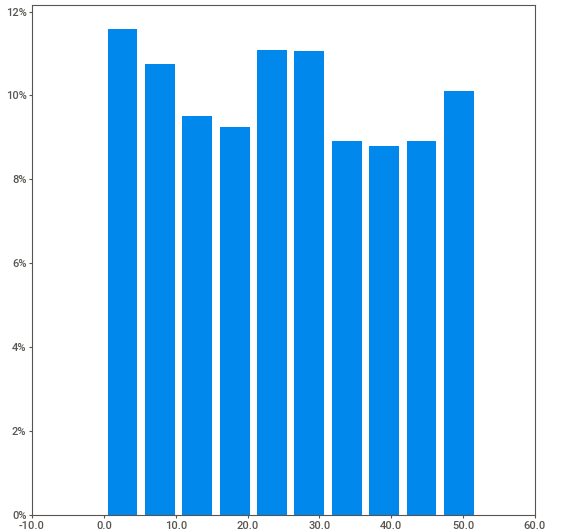
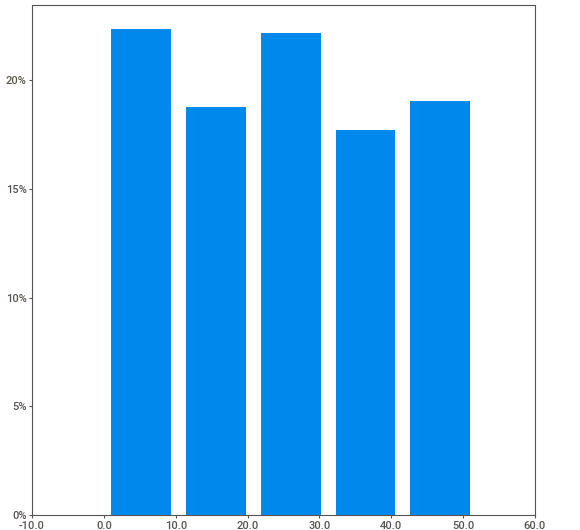
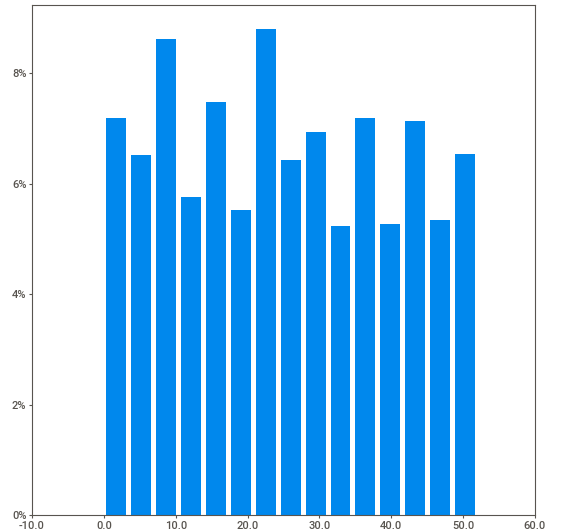
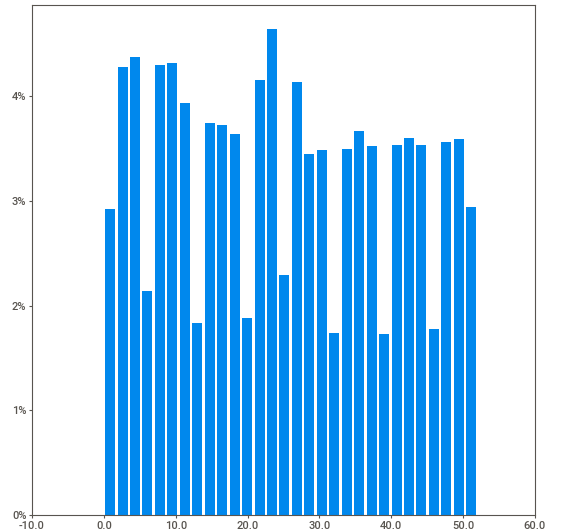
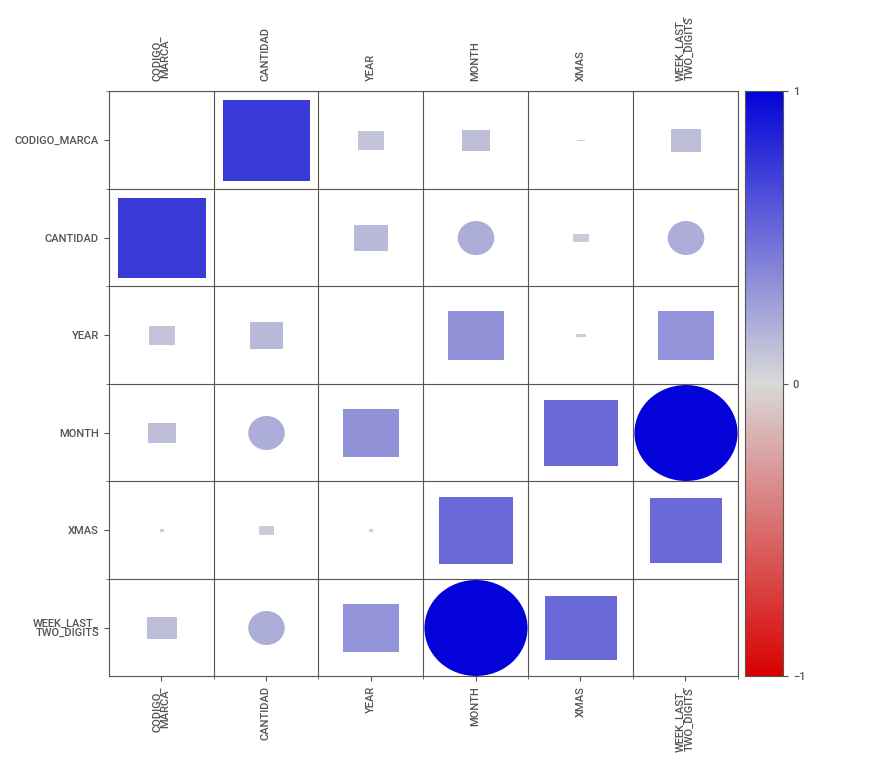
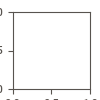

In [3]:
import sweetviz as sv
analyze_report = sv.analyze(dfPOS)
analyze_report.show_notebook(layout='vertical', scale=1.0)

Gracias al análisis de la librería __SweetViz__, podemos rápidamente comenzar a ver ciertas tendencias o características de la data. 

### Variable CODIGO_MARCA
Inicialmente habíamos determinado que `CODIGO_MARCA` era una variable que podía tomar solo tres valores: 456 para calzado, 789 para ropa, y 790 para equipo. Pero vemos que hay muchos valores más que pueden complicar innecesariamente nuestro estudio.

In [11]:
dfPOS['CODIGO_MARCA'].unique()

array([456., 457., 789., 790., 792., 793., 794., 796., 797., 798.])

La data incluye muchas categorías menores que no están propiamente detalladas en todos los archivos de datos. Ejemplo es 797, que incluye unos pocos pares de calzado de fútbol destinado no para la venta, sino para el patrocinio de jugadores de fútbol que visitan las tiendas Sportline en Colombia y reciben el producto gratis a cambio de la publicidad de estar presentes. 

### Análisis Detallado de los Datos con Columna de Variable Dependiente
La librería __SweetViz__ nos permite un nivel adicional de análisis detallado una variable como dependiente, para hacer un doble clic en la data desde el punto de vista del posible entrenamiento. 

                                             |                                                                …


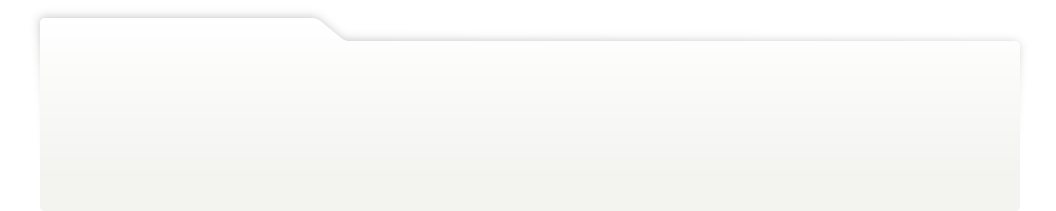
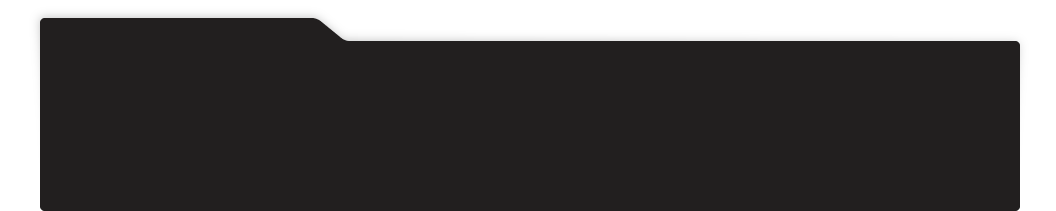
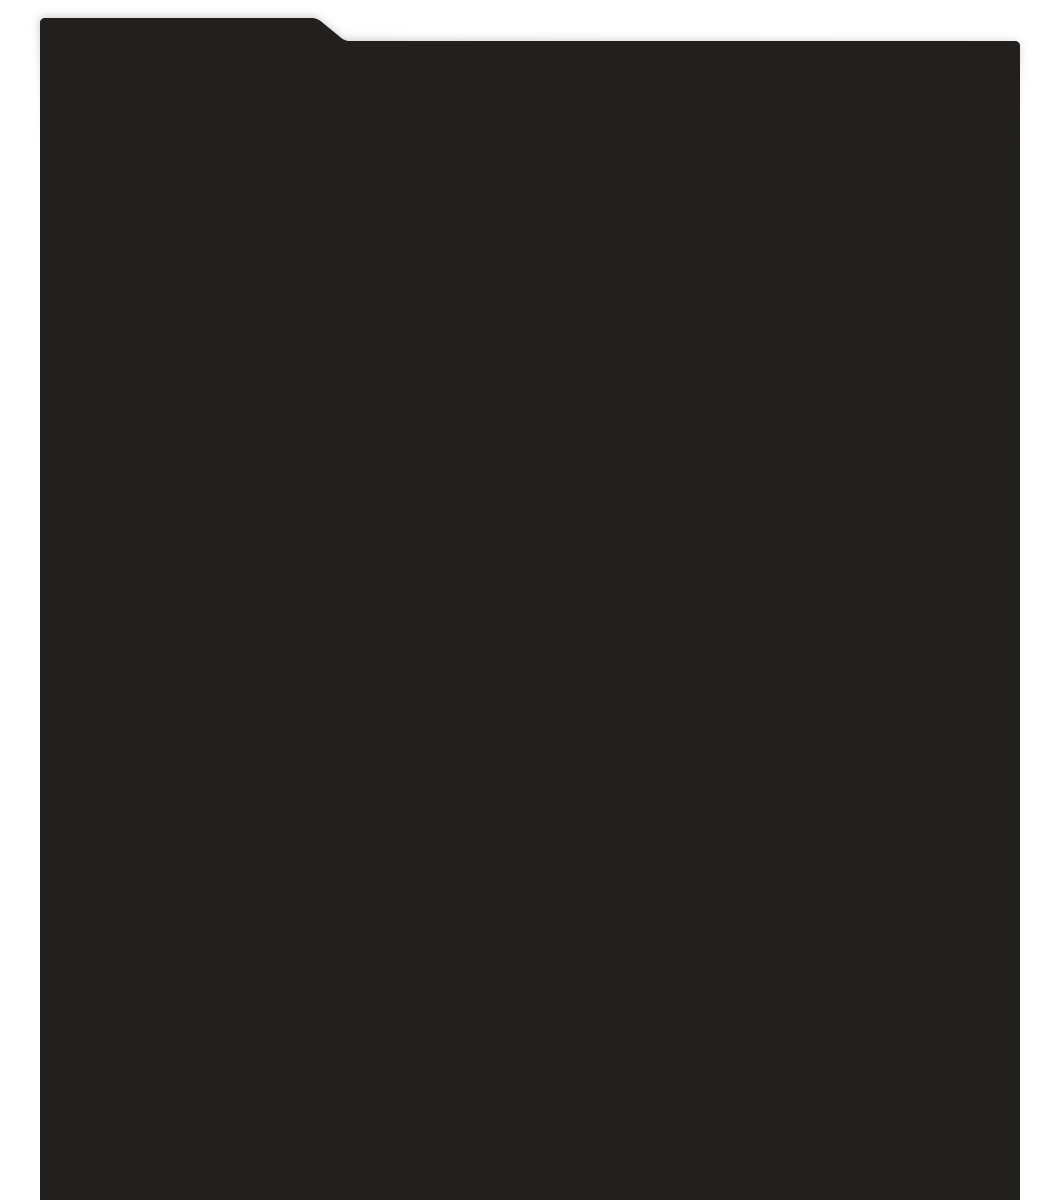
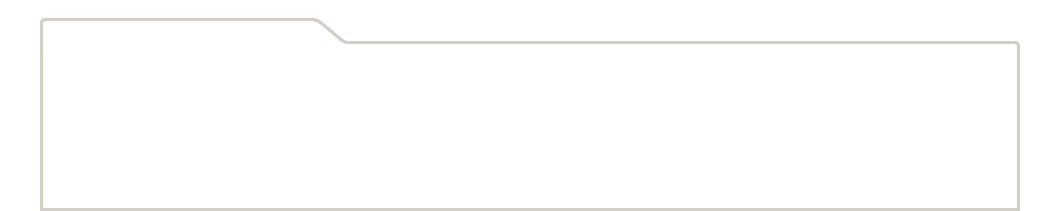
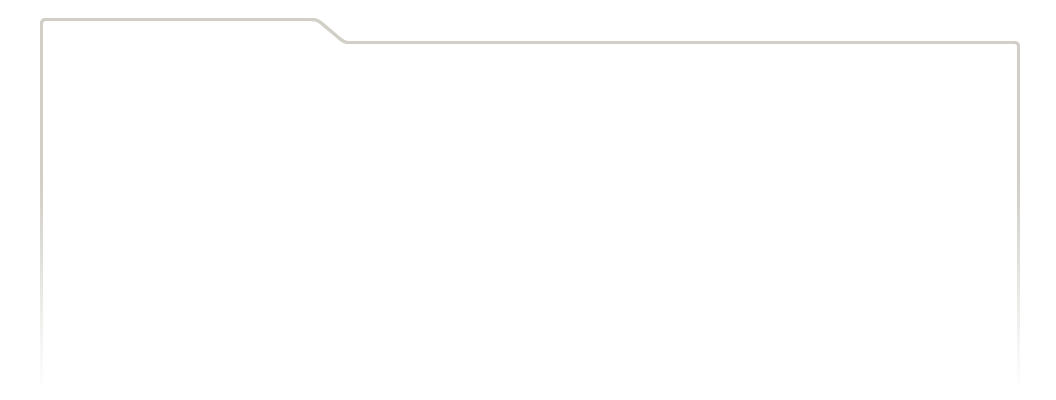
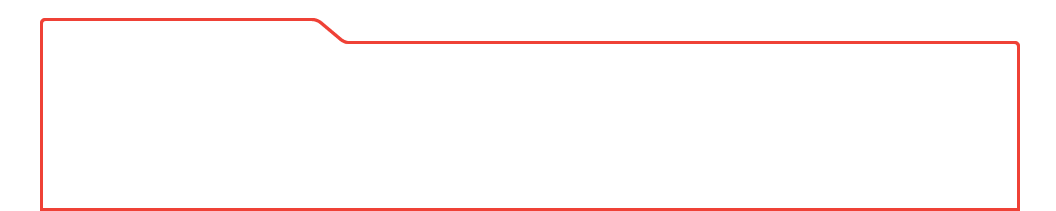
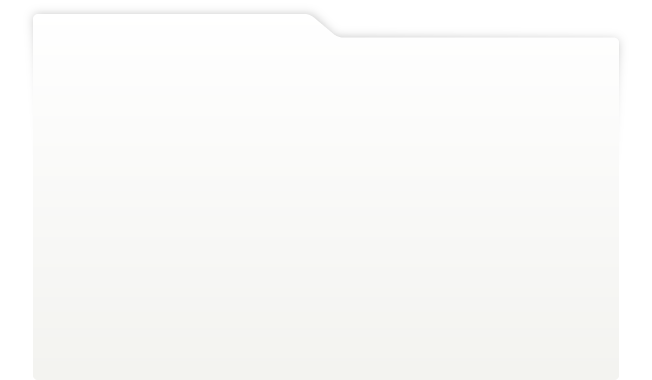
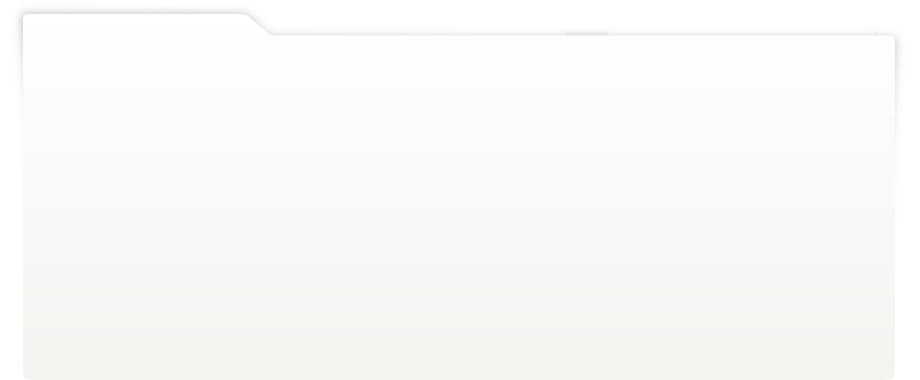
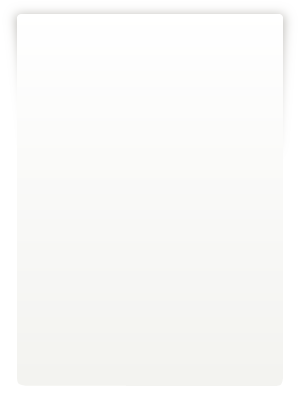
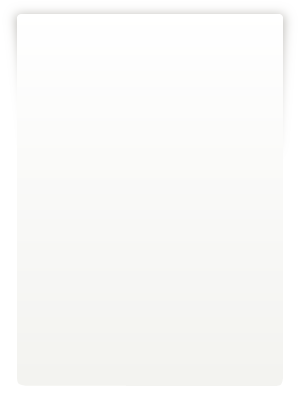
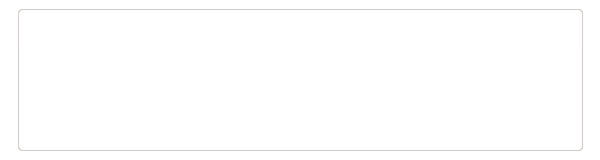
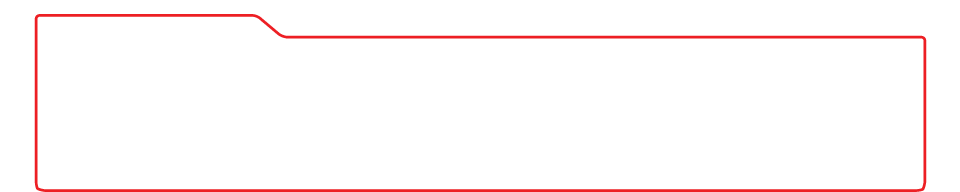
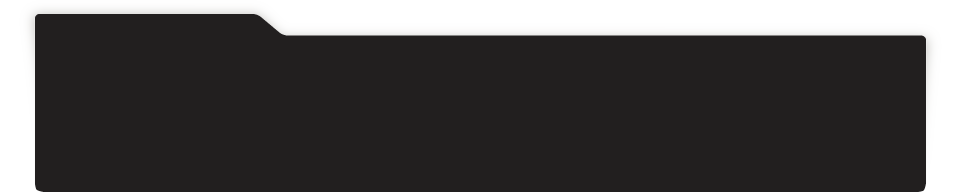
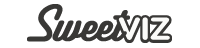
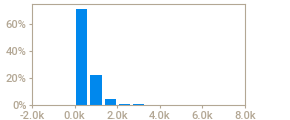
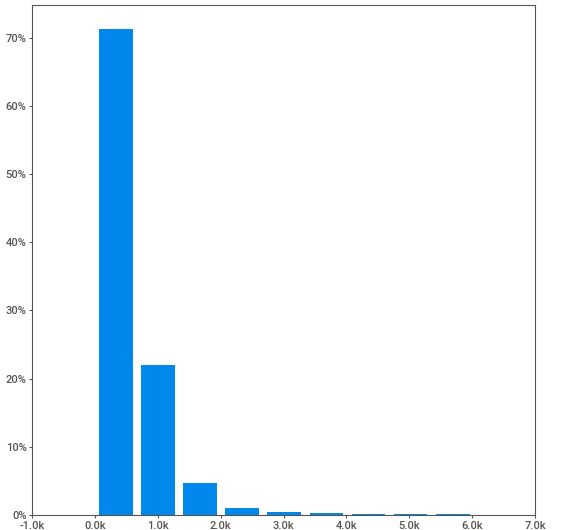
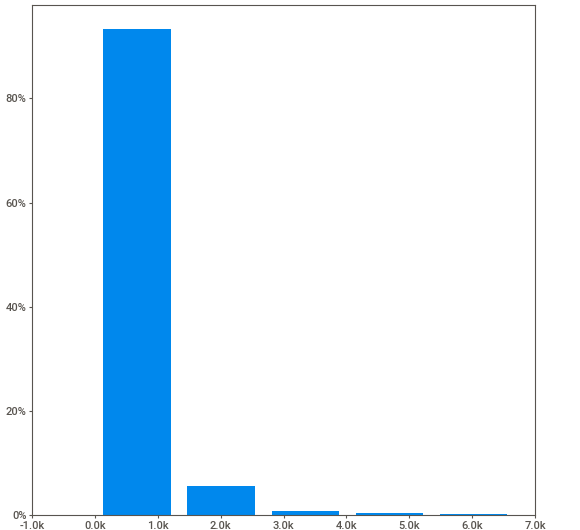
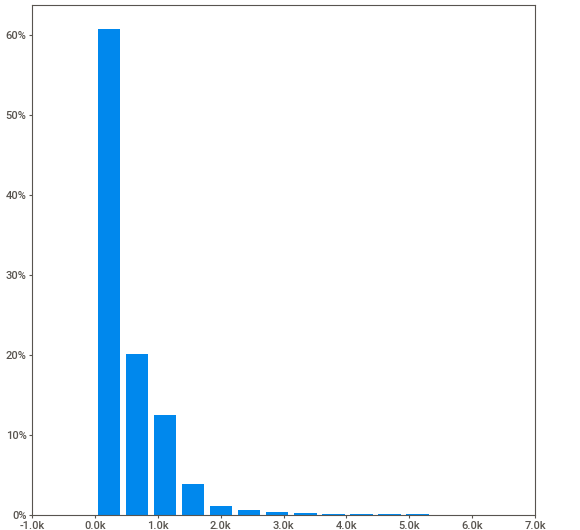
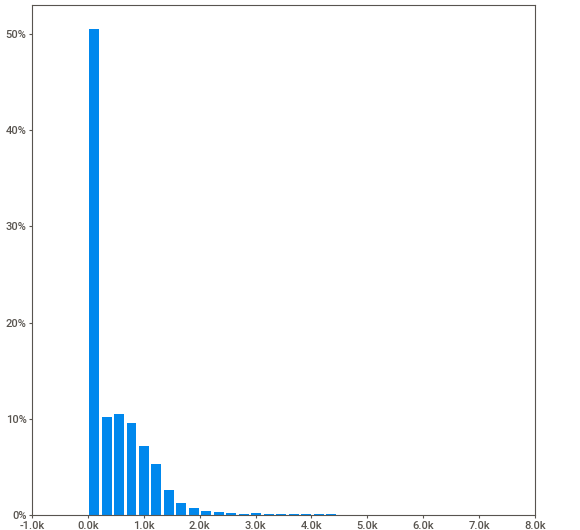
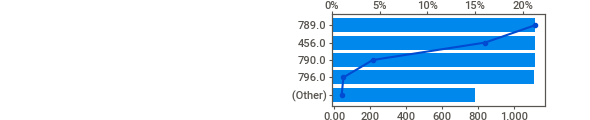
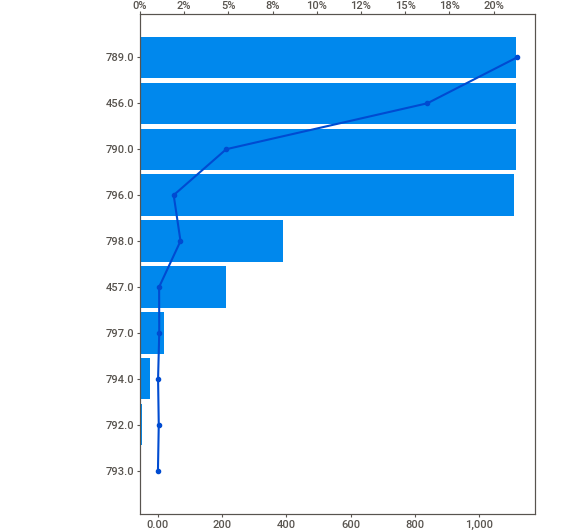
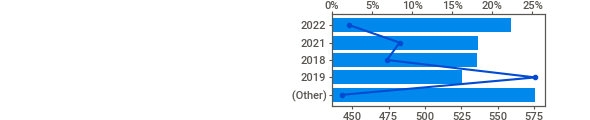
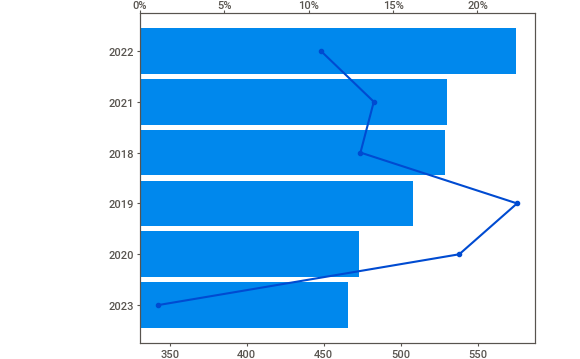
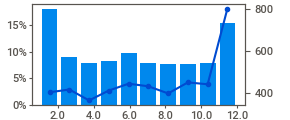
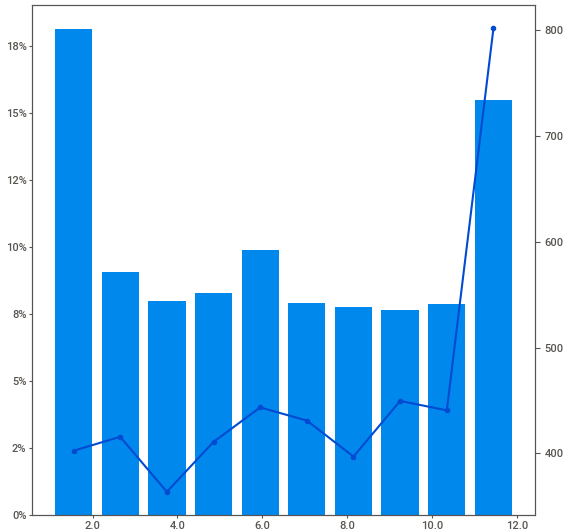
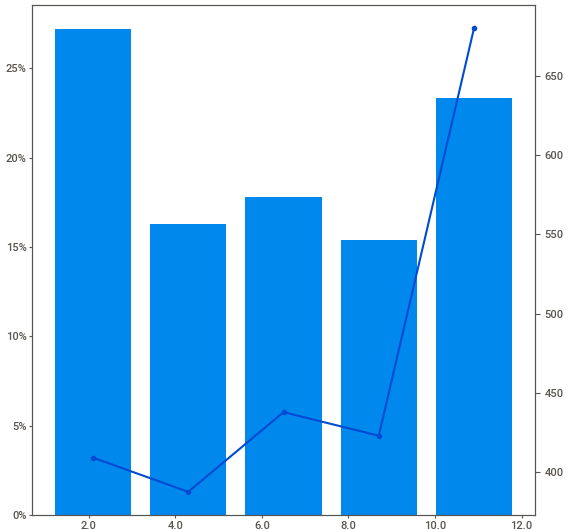
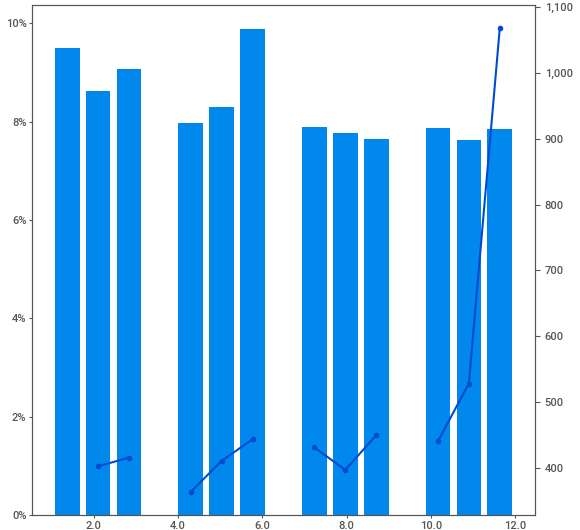
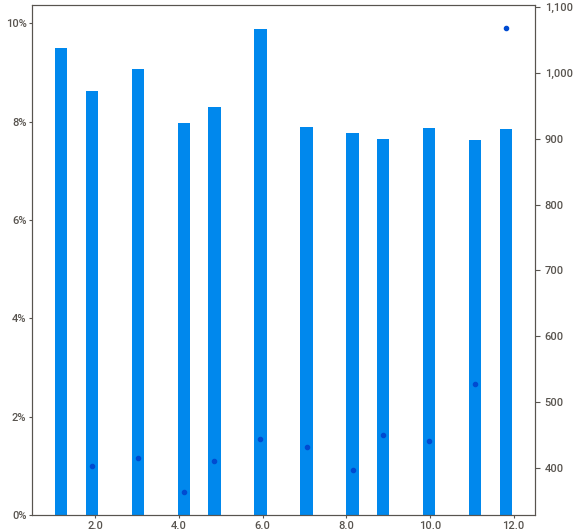
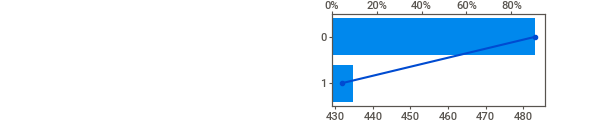
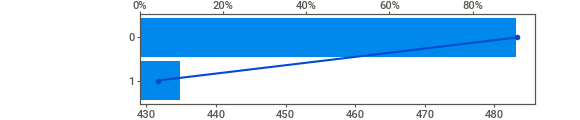
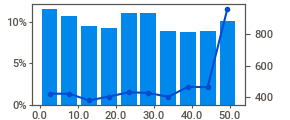
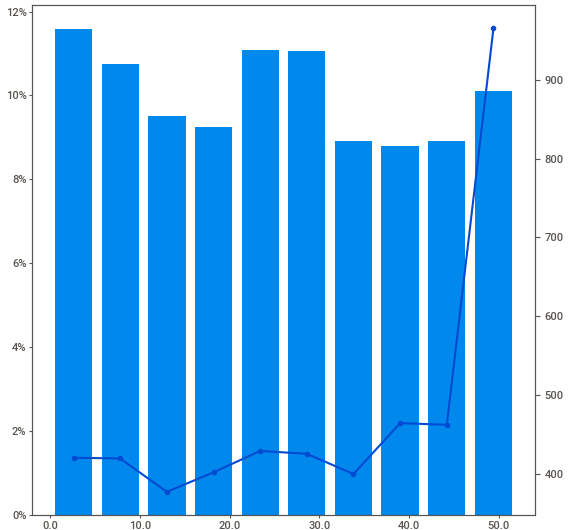
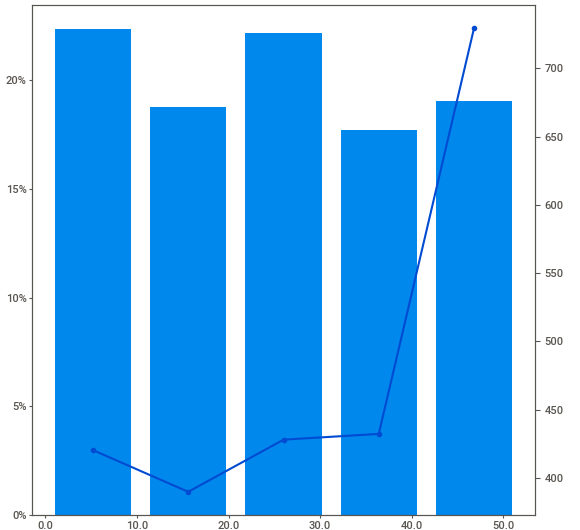
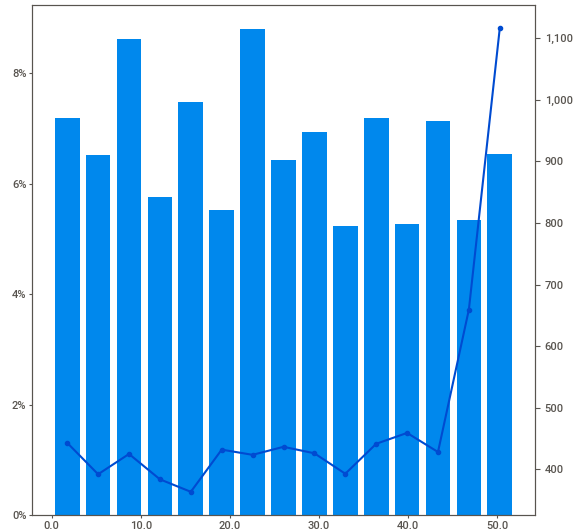
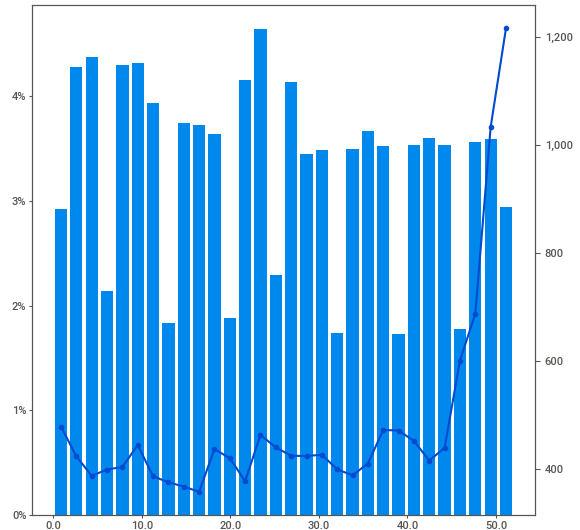
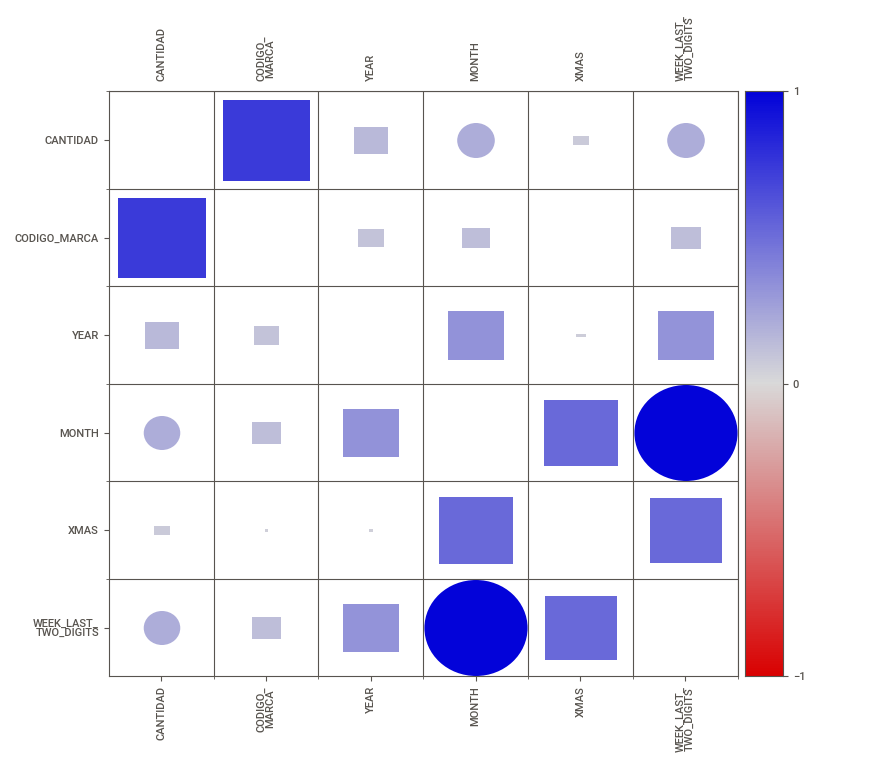
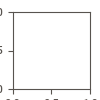

In [12]:
analyze_deep = sv.analyze(dfPOS, 'CANTIDAD')
analyze_deep.show_notebook()

El detalle más importante que salta a la vista es la correlación de la variable `CANTIDAD` con la variable `WEEK_LAST_TWO_DIGITS` que representa el número de la semana del año. Obviamente las ventas se disparan en navidad, pero eso no es algo que nos sorprenda, ya que es de esperar que la gente compre más en la época de Navidades. 

## Descompondiendo la Serie de Tiempos
La librería __SweetViz__ nos ayudó mucho con el análisis de las variables aisladas, pero debemos ver la data por lo que es, una serie de tiempo representando ventas a lo largo del año. Apliquemos la libreria __StatsModels__ para tener acceso fácil a la función `decompose` para descomponen la serie de tiempo en sus elementos primarios. 

_NOTA:_ Estaremos usando la base de datos agrupada por semanas para poder visualizar mucho mejor la tendencia, los picos y valles, y otros detalles de la serie de tiempos, ya que la data semanal es muy difícil de visualizar al ojo desnudo. 

In [46]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

csv_file_path = '/Users/ameilij/Documents/Academia/Master Data Science/MDS/tfm/data_clean/master_POS_SLA_COL_semanal.csv'
encoding = 'latin1'
grouped = pd.read_csv(csv_file_path, encoding=encoding)
grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1447 entries, 0 to 1446
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CODIGO_MARCA  1447 non-null   float64
 1   WEEK_OF_YEAR  1447 non-null   object 
 2   CANTIDAD      1447 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 34.0+ KB


In [47]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Agrupar la data por 'CODIGO_MARCA', y la semana del año
data_temp = grouped[(grouped['CODIGO_MARCA'] == 456)].sort_values(by='WEEK_OF_YEAR', ascending=True)
data_temp = data_temp[['WEEK_OF_YEAR', 'CANTIDAD']].sort_values(by='WEEK_OF_YEAR', ascending=True)

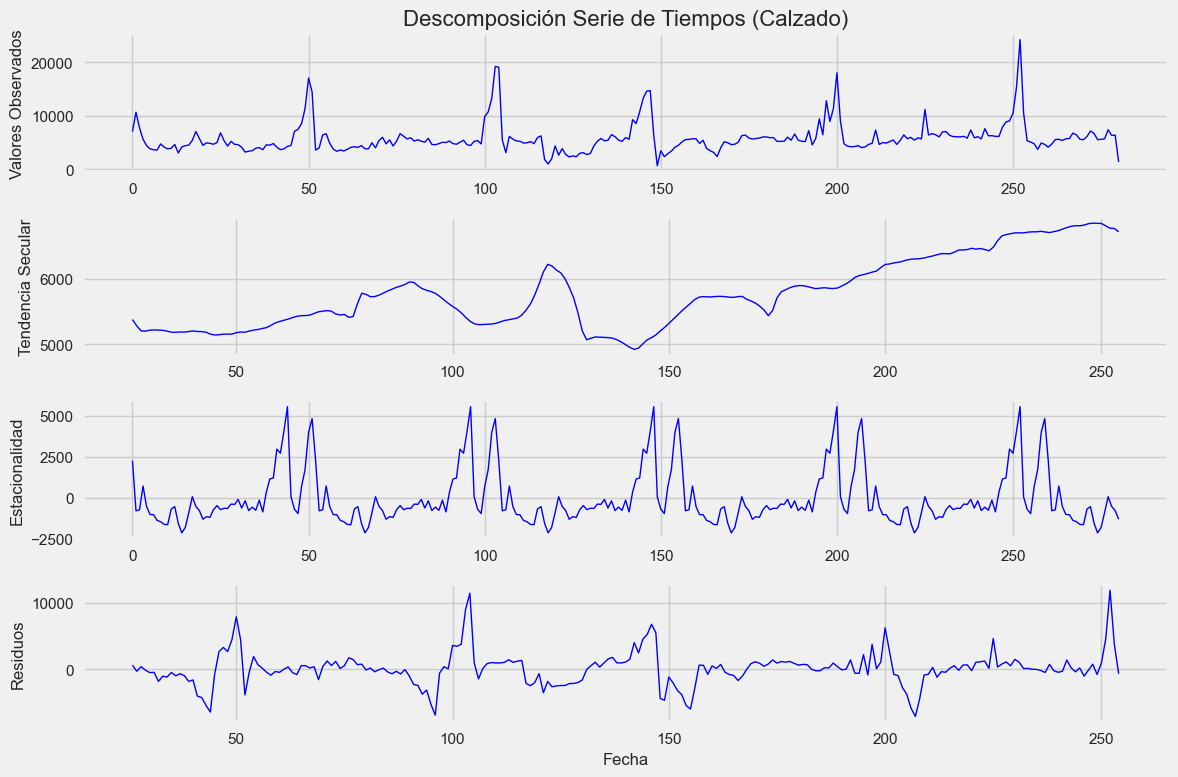

In [49]:
decomposition = sm.tsa.seasonal_decompose(data_temp['CANTIDAD'], model='additive', period=52)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
ax1.plot(decomposition.observed.index, decomposition.observed, color='blue', linewidth=1)
ax1.set_ylabel('Valores Observados', fontsize=12)

ax2.plot(decomposition.trend.index, decomposition.trend, color='blue', linewidth=1)
ax2.set_ylabel('Tendencia Secular', fontsize=12)

ax3.plot(decomposition.seasonal.index, decomposition.seasonal, color='blue', linewidth=1)
ax3.set_ylabel('Estacionalidad', fontsize=12)

ax4.plot(decomposition.resid.index, decomposition.resid, color='blue', linewidth=1)
ax4.set_ylabel('Residuos', fontsize=12)

ax1.set_title('Descomposición Serie de Tiempos (Calzado)', fontsize=16)
ax4.set_xlabel('Fecha', fontsize=12)

plt.tight_layout()
plt.show()


La gráfica que acabamos de generar es muy rica en información y debemos hacer una síntesis de cada componente primario. 

#### Valores Observados
Cuando agrupamos los valores por semana (en este caso adicionalmente para calzado) vemos el comportamiento de la serie de tiempo, con claros picos de valores alrededor de las semanas 48 a 52 (época de navidad y ventas de fin de año). Alrededor de las semanas 120 hay una clara caída de las ventas correspondiente a la época de pandemia. Esto es importante resaltarlos en los modelos de entrenamiento, quizás declarando una variable `COVID` para las fechas que hubo cierres y limitaciones a las tiendas en Colombia (marzo a finales de julio del 2020). 

#### Tendencia Secular
La tendencia secular parece marcar dos épocas en el tiempo. Una es precio a la pandemia, con un crecimiento de las ventas que se disminuye al final del 2020, y una segunda con un crecimiento sostenido desde el año 2021 hasta el final de la serie de tiempo. Esto es un poco preocupante. ¿Podrán los modelos a ser utilizados comprender el corte en la tendencia, aislarlo, y estimar con éxito el futuro? Utilizar toda la data parece ser mandatorio, pero el hecho de tener una pandemia de por medio (un evento del tipo __cisne negro__ que solo se repite en la humanidad cada cien años) pudiera tener que ser estudiado más a detalle.

#### Estacionalidad
La estacionalidad de la serie de tiempo está muy marcada y se representa con un pico bi-variable en los cierres de fin de año. Esto puede representar el hecho que la gente compra mucho antes de Navidad, el comercio para después del 25, y se reactiva hacia fin de año cuando la gente celebra, sale de vacaciones, y muchos aumentan la compra de implementos deportivos los primeros días del año para reactivar sus rutinas deportivas. 

#### Residuos
Los residuos debieran ser ruido blanco: _una serie sin forma, con media cero y desviación estándar uno_. Pero es evidente que hay un patrón de caídas y aumentos en la serie de residuos que no estamos extrayendo del modelo. Esto es un alto indicio que tener que estar alertas de señales de _heterocedasticidad_ en los modelos de entrenamiento, con mucha posibilidad de __overfitting__ sino se generalizan bien los entrenamientos. 

## Conclusiones
El análisis EDA nos ha dado muchas luces en cuanto a la fuerte estacionalidad de los datos. Estamos frente a una serie de tiempos muy típica de la industria del calzado e indumentaria, con aumentos marcados por las ventas de fin de año. A la vez, nuestros datos están parcialmente sesgados por la pandemia del 202o y la crísis del COVID-19, algo que debemos buscar señalar con el uso de _feature engineering_ en los modelos que utilicemos. 